Validation of CameraCalibration class.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners = None

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)               # Read to RGB pixel format
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

from classes import CameraCalibration
cal = CameraCalibration(imgpoints = imgpoints, objpoints = objpoints, img_size=(1280,720))
cal.save('camera_cal/validation.p')

In [2]:
from classes import CameraCalibration
cal = CameraCalibration('camera_cal/validation.p')
print("Camera center:",cal.get_ahead(0)," get_center() =",cal.get_center())

cal.camera_height = 1.44  # Advanced Lane Lines with 3.7 m lane width assumption
cal.set_ahead(638,418)
print(cal.lane())

Camera center: (669.70535693568354, 385.65623446293233)  get_center() = (669.70535693568354, 385.65623446293233)
([[251.03565705087607, 720], [607.47943882696018, 441.65789458704216], [668.52056117303982, 441.65789458704216], [1024.9643429491239, 720]], [[-1.8506981405710863, 5.571852831285072], [-1.8506981405710863, 70.05082919941604], [1.8506981405710863, 69.94917080058396], [1.8506981405710863, 5.470194432452996]], 5.521023631869034)


Validation of CameraCalibration. 

Testing undistort and handling of image collections.

RGBA image shape: (720, 1280, 4) and size: (1280, 720)
Extract G and B channels: shape = (720, 1280, 2)
Children of rgba =
 ['(( channels, 1, 3 ))', '(( undistort, <classes.CameraCalibration.CameraCalibration object at 0x7fe421fc6748> ))']
(('channels', (1, 3)),)
(('undistort', (<classes.CameraCalibration.CameraCalibration object at 0x7fe421fc6748>,)),)
RoadImage.channels: The selected range of channels must not be empty.


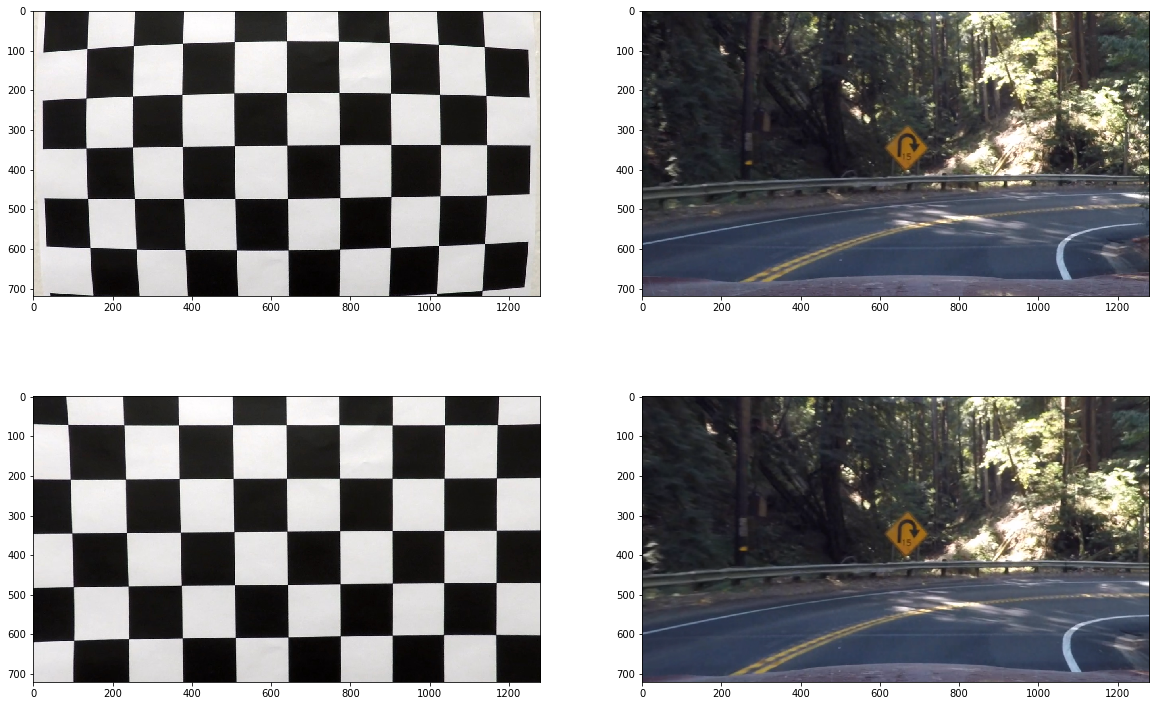

In [3]:
from classes import RoadImage, CameraCalibration
import numpy as np

# Flatten() creates a collection of 1 image (shape (1,720,1280,3))
img = RoadImage(filename='camera_cal/calibration1.jpg').flatten()
cal = CameraCalibration('camera_cal/validation.p')

from trace import Trace
tr = Trace()
#cover = tr.run("undist = img.undistort(cal)")
#print(cover)
undist = img.undistort(cal)

# Load RGBA image
rgba = RoadImage(filename='training/hard_turn_annotated.png')
print('RGBA image shape:',rgba.shape, 'and size:', rgba.get_size())
rgbaundist = rgba.undistort(cal)
rgbaundist.save('training/hard_turn_undistorted.png')
gb = rgba.channels(1,3)
print('Extract G and B channels: shape =',gb.shape)
print('Children of rgba =\n', rgba.list_children())
print(gb.find_op(rgba))
print(rgbaundist.find_op(rgba))
#import numpy as np
# Test below is filtered by @strict_accepts
#try:
#    # Pass a non-hashable number to channels to exercise generic search
#    rgba.channels(np.array([1.3]),2)
#except TypeError as e:
#    print(str(e))
    
# Pass a bad channel number to channels to exercise error checking
try:
    rgba.channels(2,2)
except ValueError as e:
    print(str(e))
    
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
ax1.imshow(img[0])
ax3.imshow(undist[0])
rgba[:,:,0:3].show(ax2)         # exercise rgba.rgb() indirectly to discard alpha layer
rgbaundist.show(ax4, alpha=False)

Validation of RoadImage class.
Constructor, numpy interoperability, cropping and casting.

3x3 input seen as 3 color pixels. Nb of channels = 3
Invert red and blue channels
c.parent is None: False
c.parent is child of d: True
c.crop_area: ((0, 0, 0), (100, 200, 3))
d_child.crop_area: ((400, 540, 0), (500, 740, 3))
d.get_crop(d): ((0, 0), (1280, 720))
c.shape: (100, 200, 3)
c.size: 60000
Cropping history:
p.shape and e.get_crop(parents...): (100, 200, 3) ((50, 25), (150, 75))
p.shape and e.get_crop(parents...): (100, 200, 3) ((50, 25), (150, 75))
p.shape and e.get_crop(parents...): (720, 1280, 3) ((590, 425), (690, 475))
Transmission of cropping history to new images:
--Return--
> <ipython-input-1-ee809a647e65>(39)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) c
p.shape and z.get_crop(parents...): (50, 100, 3) ((0, 0), (100, 50))
p.shape and z.get_crop(parents...): (100, 200, 3) ((50, 25), (150, 75))
p.shape and z.get_crop(parents...): (100, 200, 3) ((50, 25), (150, 75))
p.shape and z.get_crop(parents...): (720, 1280, 3) ((590, 425), (690, 475))
Children of d =
[['(( c

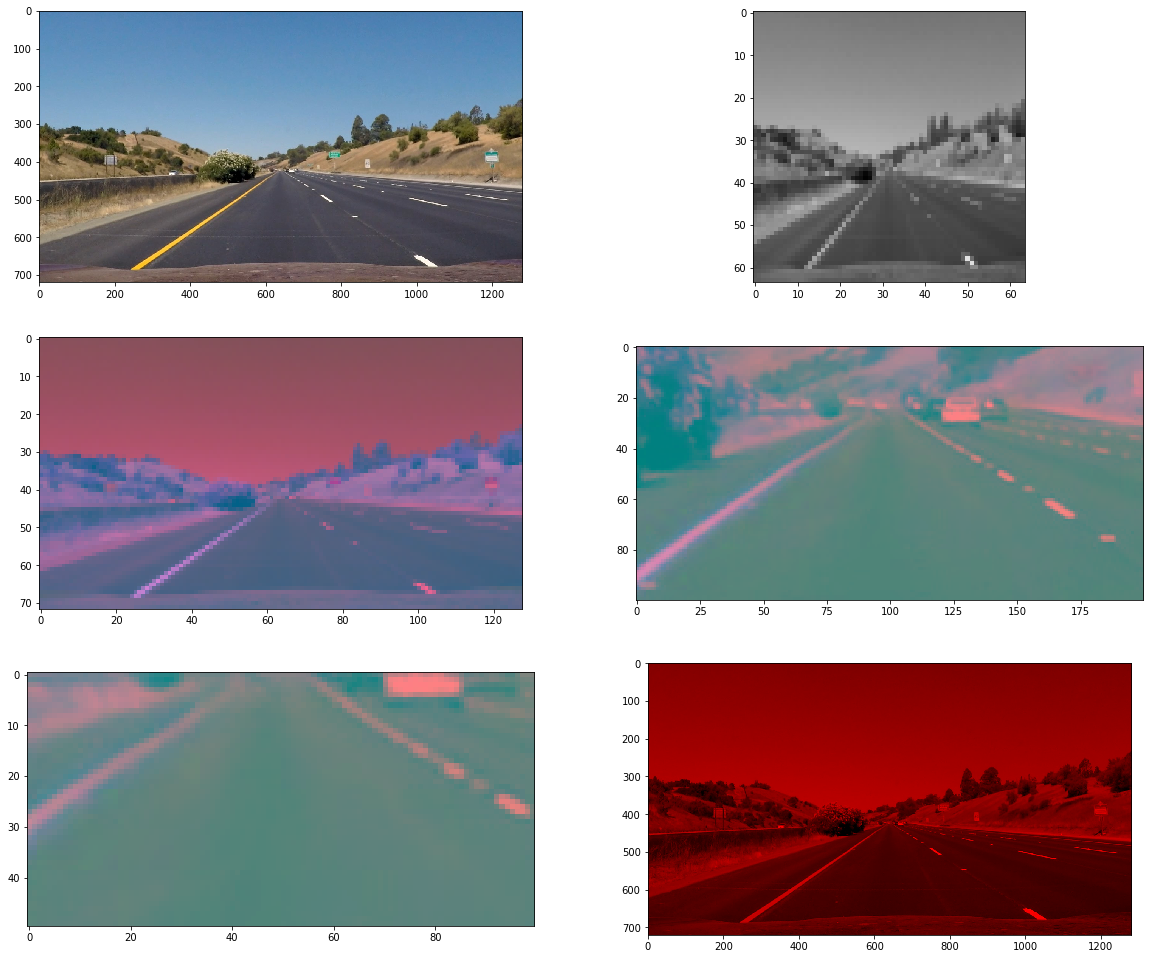

In [1]:
import numpy as np
from classes import RoadImage

# Correctly handle ambiguous vector of RGB values: silently accepted if src_cspace is given.
k= RoadImage(np.zeros(shape=(3,3)), src_cspace='RGB')
# Seen as RGB vector of pixels
print('3x3 input seen as 3 color pixels. Nb of channels =',RoadImage.image_channels(k))

# Load from file demo
d = RoadImage(filename='test_images/straight_lines1.jpg')
print('Invert red and blue channels')
e = d.channels(range(2,-1,-1)) # Invert red and blue

# Load from file into existing buffer, resizing, convert to gray, convert dtype automatically
b = RoadImage(filename='test_images/straight_lines1.jpg')\
                    .to_float().resize(w=64,h=64).to_grayscale()
# Load from file into existing buffer, resizing, convert colorspace to LUV.
a = RoadImage(filename='test_images/straight_lines1.jpg')\
       .to_int().resize(w=128,h=72).convert_color('LUV')

# Extract subimage
#c = d.convert_color('LAB')[400:500, 540:740]
c = d[400:500, 540:740].convert_color('LAB')
#print(d.list_children())
d_child = d.find_child(((RoadImage.crop,((400,540,0),(500,740,3))),))
print('c.parent is None:',c.parent is None)
print('c.parent is child of d:',c.parent is d_child)
print('c.crop_area:',c.crop_area)
print('d_child.crop_area:',d_child.crop_area)
print('d.get_crop(d):', d.get_crop(d))
print('c.shape:',c.shape)
print('c.size:',c.size)

print("Cropping history:")
e = c[25:75, 50:150]
for p in e.parents():
#    print(e.find_op(p, normal=True))
    print('p.shape and e.get_crop(parents...):',p.shape, e.get_crop(p))

print('Transmission of cropping history to new images:')
z = np.zeros_like(e)
for p in z.parents():
    print('p.shape and z.get_crop(parents...):',p.shape, z.get_crop(p))
    
print('Children of d =')
print(d.list_children())

f = d.channel(1) # Green channel
g = f.rgb()      # Green to red, zero green and blue
print('g #ch:', RoadImage.image_channels(g), ' colorspace:',g.colorspace)
import matplotlib.pyplot as plt
%matplotlib inline


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,17))
# Load from file
ax1.imshow(d)
# Load to existing buffer: resize 64x64 convert to grayscale float32
b.show(ax2,cmap='gray')
# Load to existing buffer: resize 128x72x3 uint8, convert colorspace to LUV  
ax3.imshow(a)
# Crop to zoom on distant road, convert colormap from LUV to LAB
ax4.imshow(c)
# Inverse Red and Blue channels
e.show(ax5)
# Extend single channel Green to RGB by appending 2 zero channels
g.show(ax6)

Validation of RoadImage class.

Locking / unlocking of parents.

In [7]:
from classes import RoadImage
import numpy as np
import warnings
warnings.simplefilter("always")

# Crop, flatten and channel do not make parent read-only
k= RoadImage(np.zeros(shape=(2,2,1)), src_cspace='GRAY')
k.binary=False
print('k is writeable:', k.flags.writeable)
c=k[0:1]
print('c.shape =',c.shape)
print('c.crop_area =',c.get_crop(k))
f=k.flatten()
print(k.list_children())
print('k.flatten().shape =',f.shape)
ch=k.channel(0)
print('k.channel(0).shape =',ch.shape)
print('k.channel(0).crop_area =',ch.get_crop(k))
print('k is writeable:', k.flags.writeable)
print('k is binary:', k.flatten().binary)

# Test that in-place normalization is rejected when there are children
n=k.normalize()
try:
    k.normalize(inplace=True)
except ValueError as e:
    print(str(e))
    
# Test in-place normalization on new child of k
l=(2+k).channel(0)
l.normalize(inplace=True)
print('Long op:',l.find_op())
print(l)
print('in-place done')
del l

print('normalize zeros:\n')#,n.__repr__())
print('k is writeable:', k.flags.writeable)
print(k.list_children())
raw=False
print('crop op:',c.find_op(k, raw=raw))
print('flatten_op:',f.find_op(k, raw=raw))
print('channel_op:',ch.find_op(k, raw=raw))
print('normalize_op:',n.find_op(k, raw=raw))
print('k has only auto-updating children:',RoadImage.__has_only_autoupdating_children__(k))
try:
    k[0,0] = 1
except ValueError:
    print('Writing into k generates an exception.')
print('deleting hard reference to n.')
del n
print('k has only auto-updating children:',RoadImage.__has_only_autoupdating_children__(k))
k[0,0]=1
print(k)

k is writeable: True
c.shape = (1, 2, 1)
c.crop_area = ((0, 0), (2, 1))
['(( flatten ))', '(( crop, (0, 0, 0), (1, 2, 1) ))']
k.flatten().shape = (1, 2, 2, 1)
k.channel(0).shape = (2, 2, 1)
k.channel(0).crop_area = ((0, 0), (2, 2))
k is writeable: True
k is binary: False
RoadImage.normalize: in-place operation is only allowed when there is no child.
Long op: (('channels', (range(0, 1),)), ('normalize',))
[[[ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]]]
in-place done
normalize zeros:

k is writeable: False
['(( flatten ))', '(( crop, (0, 0, 0), (1, 2, 1) ))', '(( channels, range(0, 1) ))', '(( normalize ))']
crop op: (('crop', ((0, 0, 0), (1, 2, 1))),)
flatten_op: (('flatten',),)
channel_op: (('channels', (range(0, 1),)),)
normalize_op: (('normalize',),)
k has only auto-updating children: False
Writing into k generates an exception.
deleting hard reference to n.
k has only auto-updating children: True
[[[ 1.]
  [ 0.]]

 [[ 0.]
  [ 0.]]]


Validation of RoadImage class. 

Color conversion. Children and parents.

No children yet: []
Colorspace is: RGB

Memorization test 1: unreferenced temporaries are discarded and rebuilt.
Elapsed time: 0.005105257034301758
Elapsed time: 0.003756999969482422

Memorization test 2: referenced images are linked and reused (time is shorter).
Elapsed time: 0.0023238658905029297
Elapsed time: 2.6941299438476562e-05
Only one child:  [['(( flatten ))', ['(( __numpy_like__, 48 ))']], "(( convert_color, 'YCC' ))"]
b.find_op(): (('convert_color', ('YCC',)),)
b.parent is a: True
c: ((0, 0, 0), (720, 1280, 3))
d.shape = (720, 1280, 1)
Children:  [['(( flatten ))', ['(( __numpy_like__, 48 ))']], ["(( convert_color, 'YCC' ))", [["(( convert_color, 'RGB' ))", ['(( to_grayscale ), ( normalize ))', ['(( flatten ))', [['(( crop, ((0, 0, 0), (720, 1280, 1)) ), ( channels, 0, 1 ))', ['(( __numpy_like__, 50 ))']]]]]], ['(( flatten ))', ['(( __numpy_like__, 49 ))']]]]]
b.parent is a: True
c.parent is b: True
d.parent is c: True
d was built with: (('to_grayscale',), ('normalize',))
a

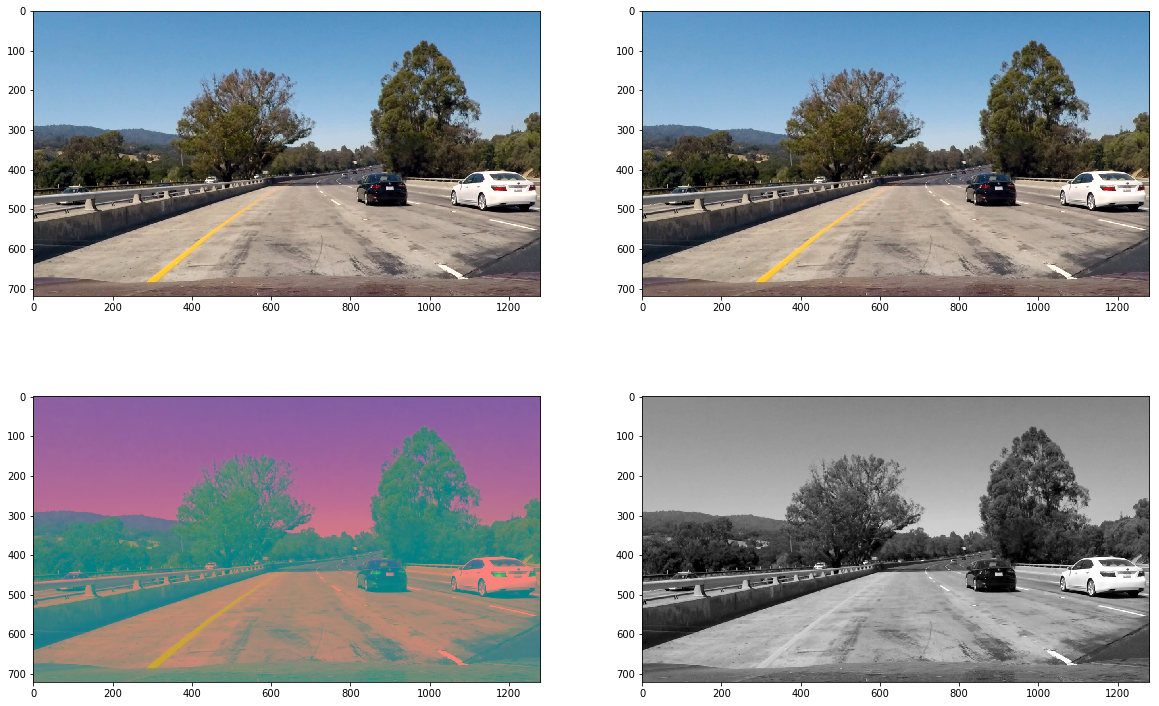

In [3]:
# Define a timing decorator
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Elapsed time: {}'.format(end-start) )
        return result
    return wrapper


from classes.RoadImage import RoadImage
a = RoadImage(filename='test_images/test1.jpg')
print('No children yet:',a.list_children())
print('Colorspace is: '+a.colorspace)

print('\nMemorization test 1: unreferenced temporaries are discarded and rebuilt.')
@timing
def f():
    a.convert_color('YCC')
   
# Check that convert_color is destroyed and rebuilt
f()
f()

print('\nMemorization test 2: referenced images are linked and reused (time is shorter).')
@timing
def g():
    return a.convert_color('YCC')

b = g()
b = g()

print('Only one child: ',a.list_children())
print('b.find_op():',b.find_op())
print('b.parent is a:',b.parent is a)
b = a.find_child(b.find_op(raw=True))
assert not(b is None) , 'b should not be None'
b = a.find_child(b.find_op(raw=False))
assert not(b is None) , 'b should not be None'
c = b.convert_color('RGB')
print('c:',c.crop_area)
d = c.to_grayscale().normalize(inplace=True)
print('d.shape =',d.shape) 
print('Children: ',a.list_children())

print('b.parent is a:',b.parent is a)
print('c.parent is b:',c.parent is b)
print('d.parent is c:',d.parent is c)
print('d was built with:',d.find_op())
print('a to d ops:',d.find_op(a))
# Can unlink c which does not share data with parent
print('c.shares_data? ',c.shares_data())
c.unlink()
print('c.parent is b:',c.parent is b)
print('d.parent is c:',d.parent is c)

# Test __numpy__ pseudo op
import numpy as np
z1 = np.zeros_like(d)
z2 = np.zeros_like(d)
print('__numpy__ children of d:', d.list_children())

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Image from file (RGB)
a.show(ax1)
# Image from file converted to YCC, then back to RGB
c.show(ax2)
# YCC image
b.show(ax3)
# Grayscale image
d.show(ax4)

Validation of RoadImage class. 

Conversion to float and to int

No children yet: []
Data type is: uint8
Children:  [['(( to_float ))', ['(( to_int ))']]]
Is a, parent of b? True
Is b, a? False
Is a, parent of c? False
Is c, a? True
Is c parent of d? False
Is b, d? False
a to d ops: (('to_float',), ('to_int',))


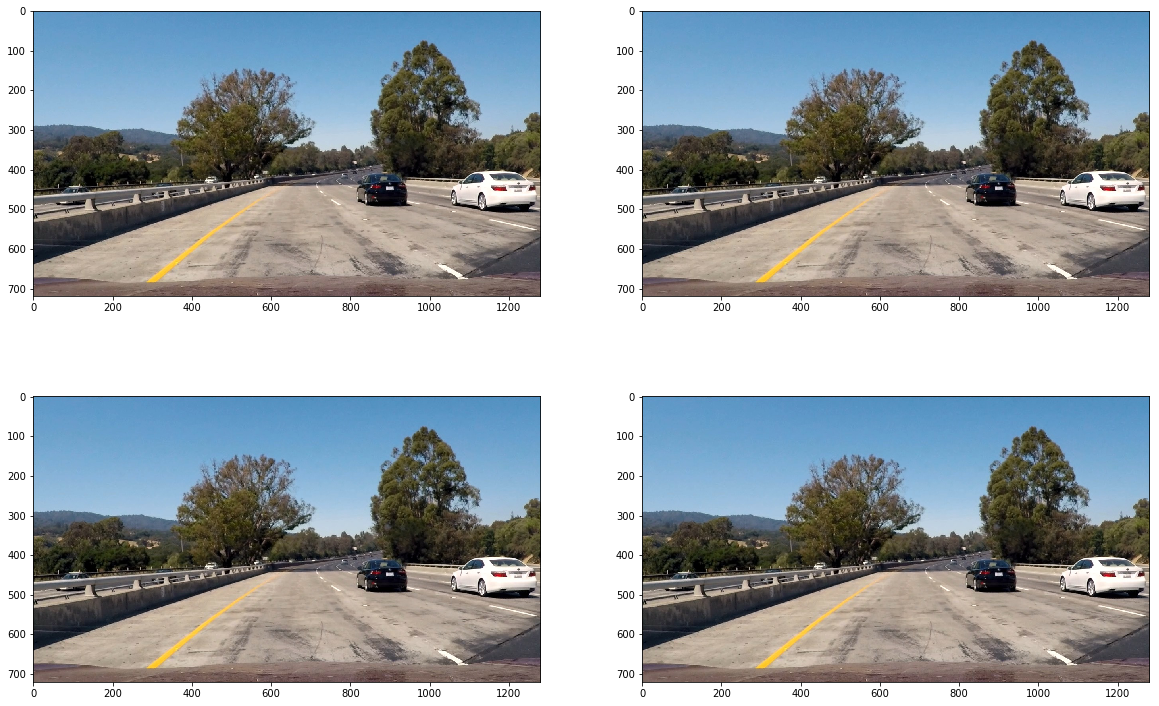

In [2]:
from classes.RoadImage import RoadImage
a = RoadImage(filename='test_images/test1.jpg')
print('No children yet:',a.list_children())
print('Data type is: '+str(a.dtype))

b = a.to_float()
c = a.to_int()
d = b.to_int()
print('Children: ',a.list_children())

print('Is a, parent of b?',b.parent is a)
print('Is b, a?',b is a)
print('Is a, parent of c?',c.parent is a)
print('Is c, a?',c is a)
print('Is c parent of d?',d.parent is c)
print('Is b, d?',d is b)
print('a to d ops:',d.find_op(a))

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Image from file (uint8) 
a.show(ax1)
# float converted
b.show(ax2)
# int converted
c.show(ax3)
# int to float, back to int converter
d.show(ax4)

Validation of RoadImage class. Per channel operations (gradient, normalize).

Take opportunity of large number of generated children to test find_common_ancestor

(720, 1280, 3)
(1, 720, 1280, 3)
True
False
((0, 0, 0), (720, 1280, 3))
Children of img:  ['(( flatten ))']
(720, 1280, 3)
<class 'classes.RoadImage.RoadImage'>
Magnitude: min= 0.0  max= 0.7333213090896606
Normalized magnitude: min= 0.0  max= 1.0
((<function RoadImage.gradients at 0x7fe41dc24488>, ('angle', 9, 0.04)),)
Children of img:  [['(( to_grayscale ))', ["(( gradients, 'y', 9, 0.04 ), ( normalize, perchannel=True, perline=True ))", "(( gradients, 'x', 9, 0.04 ), ( normalize, perchannel=True, perline=True ))"]], "(( gradients, 'y', 9, 0.04 ), ( normalize, perchannel=True, perline=True ))", "(( gradients, 'mag', 9, 0.04 ), ( normalize, perchannel=True ))", '(( flatten ))', "(( gradients, 'angle', 9, 0.04 ))", "(( gradients, 'x', 9, 0.04 ), ( normalize, perchannel=True, perline=True ))"]

find_common_ancestors( [grada, gradm, gradx, grady, copy of gradm]):

ancestors and index:
0 	 (720, 1280, 3)
1 	 (720, 1280, 3)
[0, 0, 0, 0, 1]

operations from ancestor to list element:
(('gradi

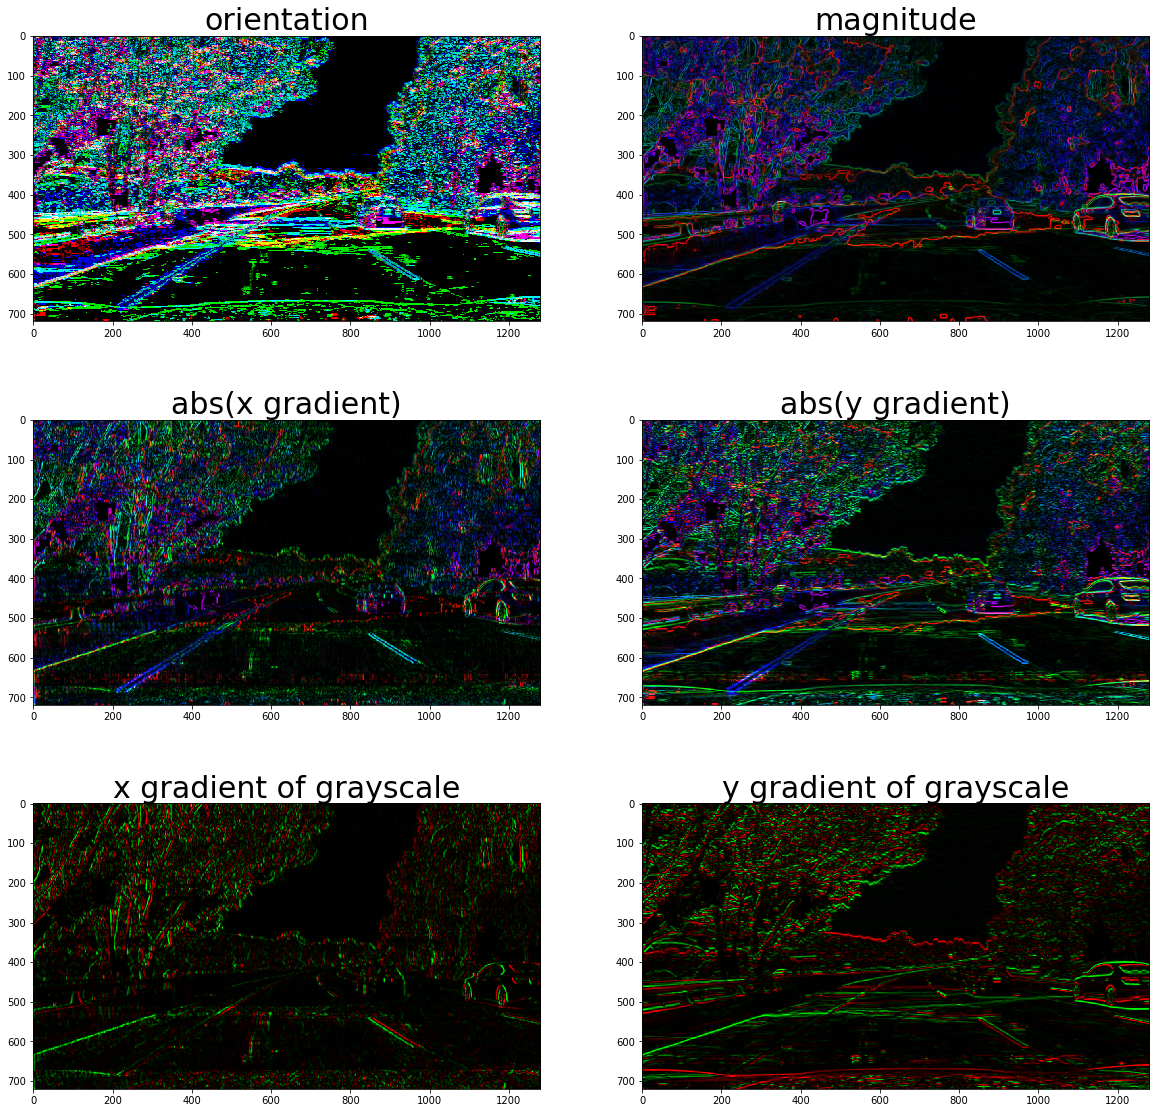

In [16]:
from classes.RoadImage import RoadImage

img = RoadImage(filename='test_images/test5.jpg', cspace='HLS')
print(img.shape)
f1 = img.flatten()
f2 = f1.flatten()
print(f2.shape)
print(f2 is f1)
print(f1 is img)
print(f1.crop_area)
print('Children of img: ', img.list_children())
grads = img.gradients(['angle','mag','x','y'], sobel_kernel=9)
(a,m,x,y) = grads
print(a.shape)
print(type(a))

import numpy as np
print("Magnitude: min=",np.min(m),' max=',np.max(m))
m.normalize(perchannel=True, inplace=True)
print("Normalized magnitude: min=",np.min(m),' max=',np.max(m))
x.normalize(perchannel=True, perline=True, inplace=True)
y.normalize(perchannel=True, perline=True, inplace=True)

gx_gray, gy_gray = img.to_grayscale().gradients(['x','y'], 
                                                sobel_kernel=9)
gx_gray.normalize(perchannel=True, perline=True, inplace=True)
gy_gray.normalize(perchannel=True, perline=True, inplace=True)

print(a.find_op(raw=True))
print('Children of img: ', img.list_children())

print('\nfind_common_ancestors( [grada, gradm, gradx, grady, copy of gradm]):')
mcopy = m.copy()
lst = grads + [mcopy]
ancestors, index = RoadImage.find_common_ancestor(lst)
print('\nancestors and index:')
for i, anc in enumerate(ancestors): print(i,'\t',anc.shape)
print(index)
print('\noperations from ancestor to list element:')
for i,image in enumerate(lst):
    print(image.find_op(ancestors[index[i]]))

print('\nfind_common_ancestors( [x,x] )...', end='')
ancestors, index = RoadImage.find_common_ancestor([x,x])
print('passed')

print('Shape of gradients:', grads[0].shape)
# Make collection
print('\nmake_collection:')
coll = RoadImage.make_collection(grads)
print('coll.type =',type(coll))
print('coll.shape =',coll.shape)
print('coll.parent is img?', coll.parent is img)
print('long op from img:', coll.find_op(img, raw=False))

coll = RoadImage.make_collection([coll,coll], concat=True)
print('coll.shape =',coll.shape)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
# Angle of gradient 
a.show(ax1,title="orientation")
# Magnitude of gradient
m.show(ax2,title="magnitude")
# x gradient
np.abs(x).show(ax3,title="abs(x gradient)")
# y gradient
np.abs(y).show(ax4,title="abs(y gradient)")
# x gradient of grayscale
gx_gray.show(ax5,title="x gradient of grayscale")
# y gradient of grayscale
gy_gray.show(ax6,title="y gradient of grayscale")


Validation of class RoadImage.

Validation of morphological methods: despeckle

Image shape: (100, 100, 1)
Image A binary? True
Image B binary? True


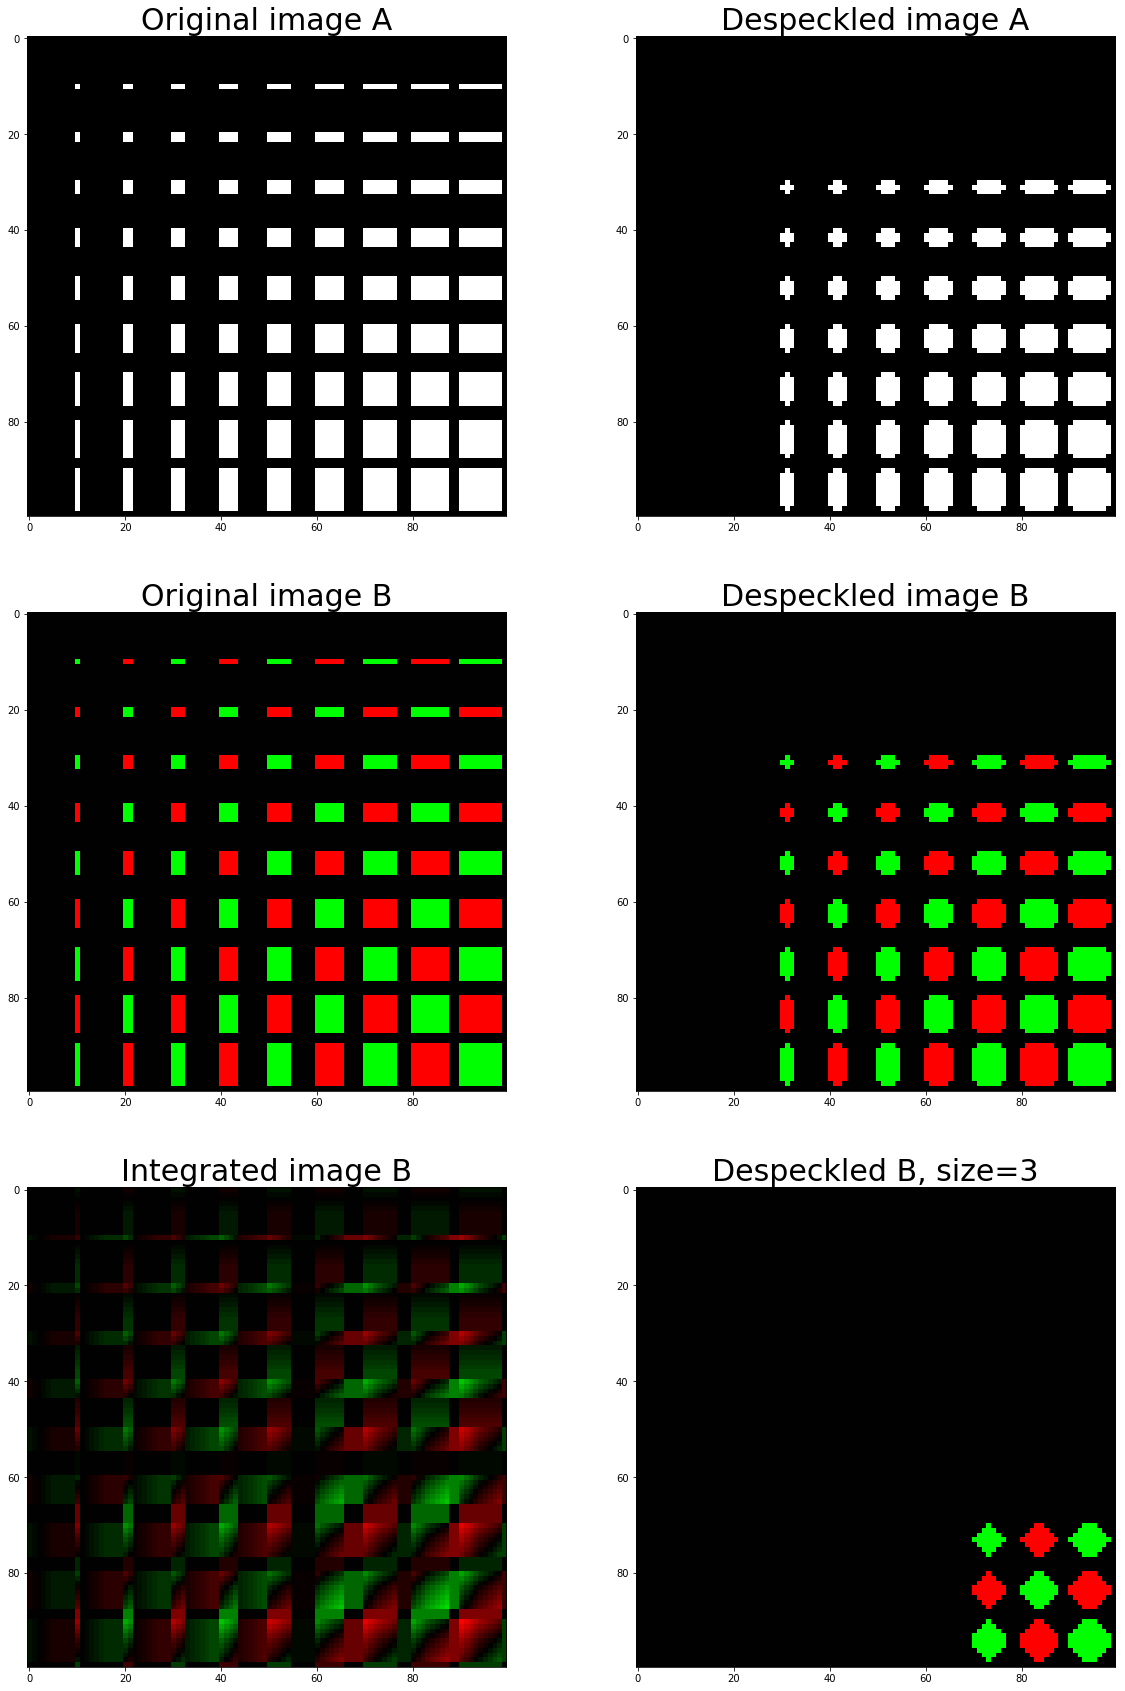

In [17]:
from classes import RoadImage
import numpy as np
import cv2

a = np.zeros(shape=(100,100), dtype=np.uint8)
b = np.zeros(shape=(100,100), dtype=np.float32)

# Draw dots of various sizes and shapes
for w,x in enumerate(range(10,100,10)):
    for h,y in enumerate(range(10,100,10)):
        cv2.rectangle(a, (x,y), (x+w,y+h), 1, -1, shift=0)
        if (w+h)%2==0: col=1
        else:          col=-1
        cv2.rectangle(b, (x,y), (x+w,y+h), col, -1, shift=0)

# Make RoadImage
imgA = RoadImage(a, src_cspace='GRAY')
print("Image shape:",imgA.shape)
imgB = RoadImage(b, src_cspace='GRAY')
imgB.gradient=True
print("Image A binary?", imgA.binary)
print("Image B binary?", imgB.binary)
imgE = imgB.integrate(ksize=100).normalize()

# Display img and masks as HLS
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,30))
imgA.show(ax1, title='Original image A')
imgA.despeckle(inplace=True)
imgA.show(ax2, title='Despeckled image A')
imgB.show(ax3, title='Original image B')
imgC = imgB.despeckle(inplace=False)
imgC.show(ax4, title='Despeckled image B')
imgE.show(ax5, title='Integrated image B')
imgD = imgB.despeckle(size=3)
imgD.show(ax6, title='Despeckled B, size=3')

Validation of class RoadImage.

Validation of thresholding of images and gradients.

Loaded shape: (720, 1280, 3)
copy.dtype = uint8
copy.binary = True
copy.gradient = False
match_shape: (1, 1, 3)
mask colorspace: GRAY
mask is binary: True
mask.shape = (720, 1280, 1)
mask is grayscale: True
mask dtype: float32
min(g) = 0.0 max(g) = 1.0
a is gradient: False
m is gradient: False
x is gradient: True
g is gradient: True
g is binary: True
g is gradient: True
g is binary: True
g.shape = (1, 720, 1280, 1)


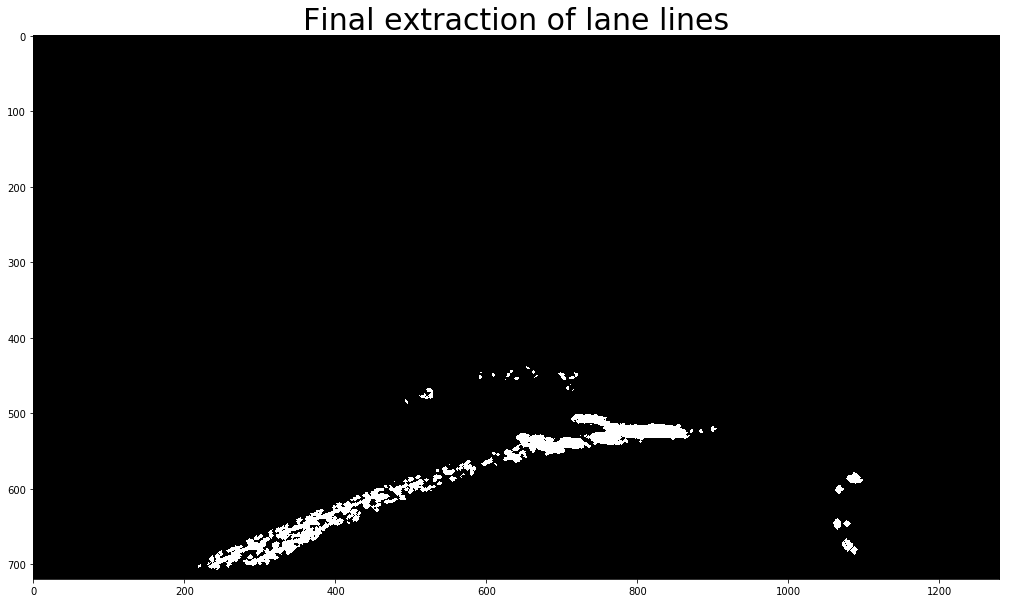

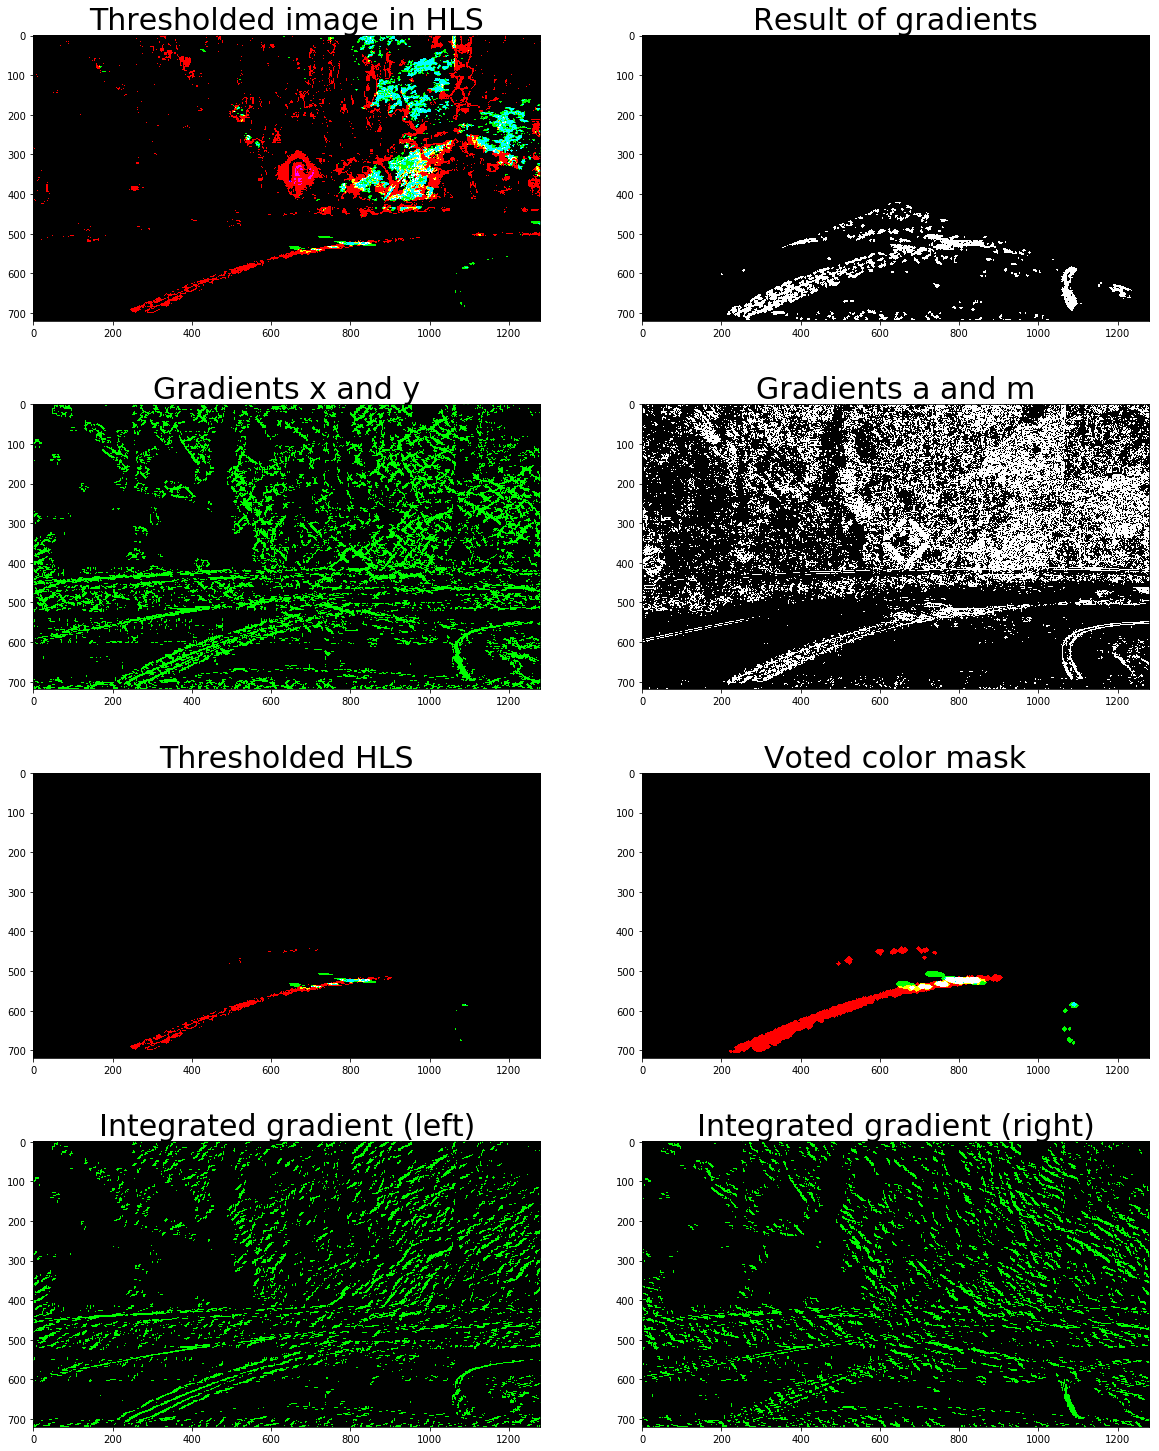

In [18]:
from classes import RoadImage, CameraCalibration
import numpy as np

cal = CameraCalibration('camera_cal/validation.p')

#crop = ((500,400),(780,500))
crop = ((0,0),(1280,720))
file = 'hard_turn'
#img = RoadImage(filename='test_images/straight_lines1.jpg',
img = RoadImage(filename='test_images/'+file+'.jpg',
                cspace='HLS').undistort(cal).crop(crop)
print('Loaded shape:',img.shape)
# We have per channel min and max (for H,L and S)
mini = np.array([0.0627, 0.762, 0.75])
maxi = np.array([0.0863, 1.0,   1.0])
copy = img.copy()
print('copy.dtype =',copy.dtype)
copy.threshold(mini=mini, maxi=maxi, inplace=True)
print('copy.binary =',copy.binary)
print('copy.gradient =',copy.gradient)
print('match_shape:',RoadImage.__match_shape__(mini.shape, copy.shape))

mask = RoadImage(filename='training/straight_mask.png').crop(crop)
# Make mask truly binary
mask.threshold(mini=0.5, inplace=True)
print('mask colorspace:', mask.colorspace)
print('mask is binary:', mask.binary)
print('mask.shape =',mask.shape)
print('mask is grayscale:',RoadImage.is_grayscale(mask))
print('mask dtype:', mask.dtype)
# Not inplace
imini = mini.reshape((1,)+mini.shape)
imaxi = maxi.reshape((1,)+maxi.shape)
# Small constant ensures that mini > maxi in areas where mask = 0
# Needs img.to_float to have an effect.

# Combine gradients to make a 2D HLS image:
minimask = 0.0001+np.tensordot(mask,imini, axes=([2],[0])) 
maximask = np.tensordot(mask,imaxi, axes=([2],[0])) 
thresh = img.to_float().threshold(mini=minimask, maxi=maximask)

# Add gradient info
grads = img.gradients(['angle','mag','x','y'], sobel_kernel=9)
(a,m,x,y) = grads
a.threshold(mini=np.array([0.266,0.269,0.265]),
            maxi=np.array([0.64,0.661,0.685]), inplace=True)\
    .despeckle(size=2)
m.normalize(perchannel=True, inplace=True)\
    .threshold(mini=np.array([0.352,0.298,0.327]),
               maxi=np.array([0.623,0.707,0.705]),inplace=True)\
    .despeckle(size=2)
x.normalize(perchannel=True, perline=True, inplace=True)\
    .threshold(mini=np.array([0.304,0.3,0.302]),
               maxi=np.array([0.687,0.707,0.707]),inplace=True)
#    .despeckle(size=5)
y.normalize(perchannel=True, perline=True, inplace=True)\
    .threshold(mini=np.array([0.28,0.278,0.282]),
               maxi=np.array([0.684,0.707,0.706]),inplace=True)
#    .despeckle(size=5)

# Left half
gleft = RoadImage.make_collection([x,y])\
    .combine_masks('or', perchannel=False)\
    .integrate(ksize=20, invertx=False)
# Cancel negative part
gleft[(gleft<0)] = 0
center = gleft.shape[-2]//2
gleft[0,:,:center].normalize(inplace=True, perline=True)
gleft[0,:,center:].normalize(inplace=True, perline=True)
gleft.threshold(mini=0.3, inplace=True)

# Right half: change sign of x and use integrate(invertx=True)
xinv = x.invert()
gright = RoadImage.make_collection([xinv,y])\
    .combine_masks('or', perchannel=False)\
    .integrate(ksize=20, invertx=True)
# Cancel negative part
gright[(gright<0)] = 0
center = gright.shape[-2]//2
gright[0,:,:center].normalize(inplace=True, perline=True)
gright[0,:,center:].normalize(inplace=True, perline=True)
gright.threshold(mini=0.3, inplace=True)

g = RoadImage.make_collection([gleft,gright], concat=True)\
    .combine_masks('or')

print('min(g) =',np.min(g), 'max(g) =',np.max(g))
print('a is gradient:', a.gradient)
print('m is gradient:', m.gradient)
print('x is gradient:', x.gradient)
print('g is gradient:', g.gradient)
print('g is binary:',g.binary)

gam = RoadImage.make_collection([a,m])\
    .combine_masks('or', perchannel=False)
# Combine gradients A,M with X,Y
# Since gam and g are collections, make_collection creates a new
# dimension in the collection structure, which combine_masks collapses
# to length 1, but keeps around.
gmask = RoadImage.make_collection([gam,g], concat=True)\
    .combine_masks('or').despeckle(size=2, inplace=True)
    
#gr = RoadImage.make_collection([gmask,mask.flatten()], concat=True)\
#    .combine_masks('and')
gr = gmask.apply_mask(mask, inplace=True)

colors = thresh.dilate(iterations=5).to_float().flatten()
                                
final = RoadImage.make_collection([
    colors.channel(0), colors.channel(1), colors.channel(2),
    gr #gam.dilate(iterations=2), g
], concat=True).combine_masks(2, perchannel=False)

print('g is gradient:', g.gradient)
print('g is binary:',g.binary)
print('g.shape =',g.shape)

# Display img and masks as HLS
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1,1, figsize=(20,10))
final.show(ax, title='Final extraction of lane lines')

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(20,26))

copy.show(ax1, title='Thresholded image in HLS')
gr.show(ax2, title='Result of gradients')
g.show(ax3, title='Gradients x and y')
gam.show(ax4, title='Gradients a and m')
thresh.show(ax5, title='Thresholded HLS')
colors.show(ax6, title='Voted color mask')
gleft.show(ax7, title='Integrated gradient (left)')
gright.show(ax8, title='Integrated gradient (right)')

final.save('output_images/lines_'+file+'.png')

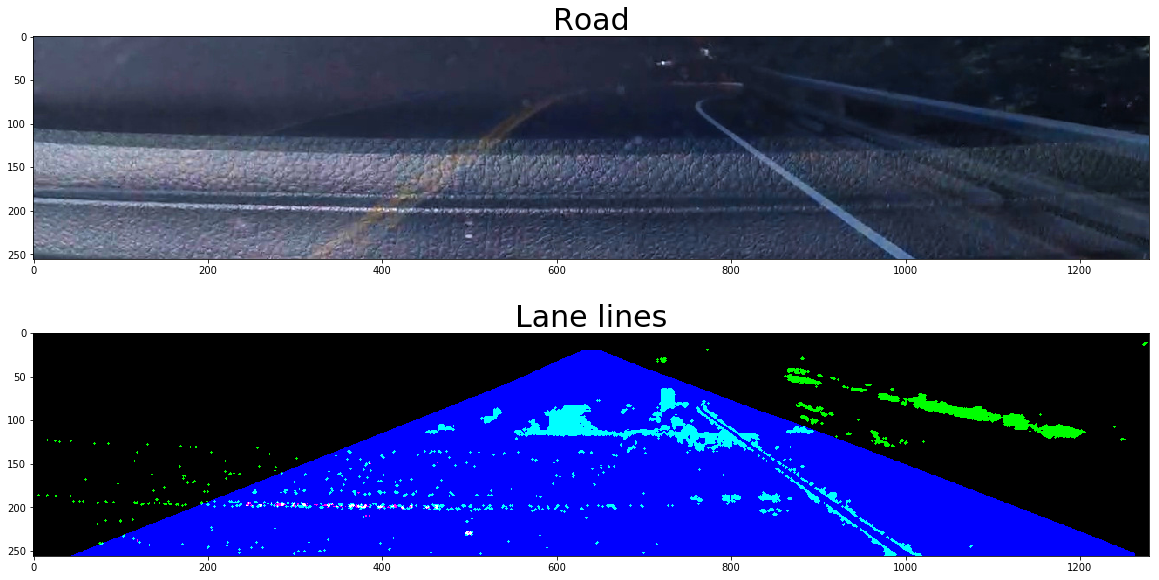

In [15]:
from classes import RoadImage, CameraCalibration
import numpy as np

ycrop=range(400,656)

cal = CameraCalibration('camera_cal/validation.p')
mask = RoadImage(filename='training/straight_mask.png')
mask = mask[ycrop].threshold(mini=0.5)

#file = 'hard_turn'
#file='straight_lines1'
#file='test5'
#file='input0073'
#file='input0001'
#file='test1'
file='input0922'
file='input0922-autoTSV'

img = RoadImage(filename='test_images/'+file+'.jpg')
img = img[ycrop]

lrmask = np.ones_like(img.channel(0), dtype=np.uint8)
lrmask[:,0:600,:] = 0
lrmask.binary=True

lines = img.extract_lines(lrmask = lrmask, mask = mask)

hsV = img.convert_color('HSV').channel(2).threshold(mini=50/255)
hlS = img.convert_color('HLS').channel(2).threshold(mini=100/255)
gradx,grady = img.to_grayscale().gradients(tasks=['absx','absy'])
gradx.normalize(inplace=True).threshold(mini=12/255, inplace=True)
grady.normalize(inplace=True).threshold(mini=25/255, inplace=True)
color=RoadImage.make_collection([hsV, hlS]).combine_masks('and')
gxy = RoadImage.make_collection([gradx.to_int(), grady.to_int()]).combine_masks('and')
layer = RoadImage.make_collection([gxy, color]).combine_masks('or').despeckle()

#lines.save('output_images/lines_'+file+'.png')

result = np.zeros_like(img, dtype=np.float32)
result.channel(0)[:] = lines
result.channel(1)[:] = layer
result.channel(2)[:] = mask

# Display img and warped image
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1,ax2) = plt.subplots(2,1, figsize=(20,10))
img.show(ax1, title='Road')
result.show(ax2, title='Lane lines')



Now that the best information from the colors and the gradients is combined, we can warp the image to eliminate the perspective effect.

Warped images appear with the same crop as the corresponding unwarped image.
Anc. Warped? Crop
 0:  False       ((0, 0), (1280, 282))  warp
 1:  True        ((0, 0), (1280, 282))  warp
 2:  False       ((0, 0), (1280, 282))  channels
 3:  False       ((0, 0), (1280, 282))  crop
 4:  False     ((0, 418), (1280, 700))  


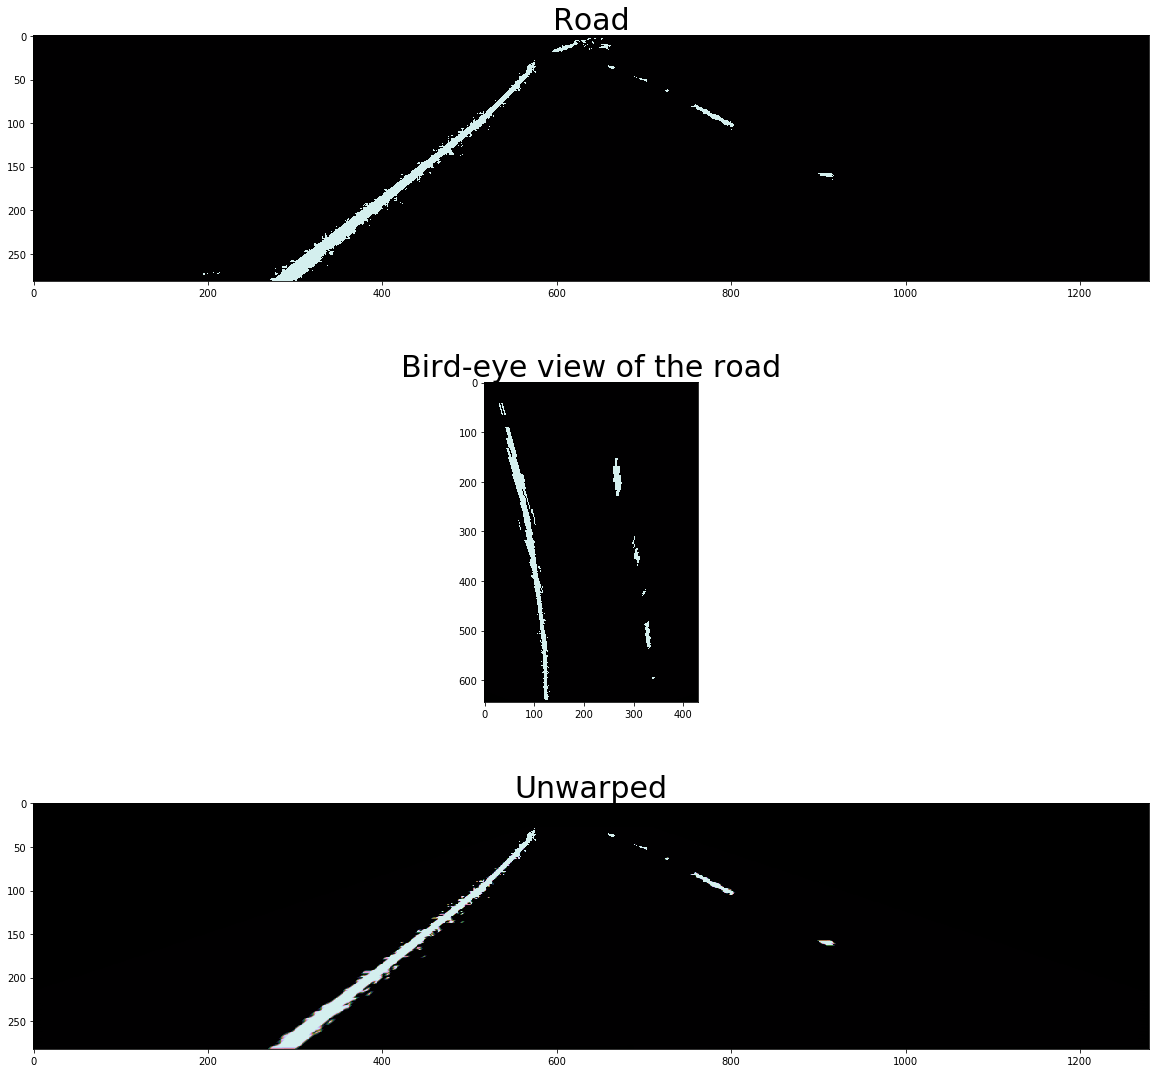

In [1]:
from classes import RoadImage, CameraCalibration
import numpy as np
import cv2
from itertools import chain

#file = 'hard_turn'
file = 'straight_lines1'
#file = 'test5'
#file = 'test6'
file = { 'n':'input0073', 'h':-0.2 }

# Load undistorted image of lane lines
img = RoadImage(filename='output_images/lines_'+file['n']+'.png')

# Optional crop : does not change top view, but saves processing time#
img = img[418:700]

img = img.channel(1).to_float()

cal = CameraCalibration('camera_cal/validation.p')
cal.camera_height = 1.44
cal.set_ahead(638,418)

w, origin = img.warp(cal, h=file['h'])
# For hard_turn
#w = img.warp(cal, z=20, scale=(.02,.02), curvrange=(-0.001, 0.05))

#img = cv2.resize(np.array([[0,1]]), img.get_size(), interpolation=cv2.INTER_NEAREST)
#img = RoadImage(img, src_cspace='GRAY')
#print(img.shape, RoadImage.image_channels(img))

back = w.unwarp(h=file['h'])

print('Warped images appear with the same crop as the corresponding unwarped image.')
print('Anc. Warped? Crop')
for i,p in enumerate(chain([back],back.parents())):
    ops=p.find_op(p.parent, quiet=True, raw=False)
    if ops: name_op = ops[0][0]
    else:   name_op = ''
    print('%2d:  %-5s  %26s '%(i, str(p.warped), str(back.get_crop(p))),
          name_op)
# Display img and warped image
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,20))
img.show(ax1, title='Road')
w.show(ax2, title='Bird-eye view of the road')
back.show(ax3, title='Unwarped')

w.save('output_images/warped_'+file['n']+'.png')


Validation of class Line

Importing the module. Listing registered implementations.

In [1]:
from classes import Line
print('Available Line implementations:', Line.Implementations())
try:
    Line.Set_Default('totoline')
except ValueError as e:
    print(str(e))
print('Default Line implementation:', Line.Get_default())
try:
    line = Line.Factory()
except ValueError as e:
    print(str(e))
# Call __init__ directly
try:
    line = Line()
except TypeError as e:
    print(str(e))

from classes import LinePoly
# LinePoly becomes the default implementation
print('Available Line implementations:', Line.Implementations())
print('Default Line implementation:', Line.Get_default())
line = Line.Factory()
print('Got a',type(line))

import numpy as np
# Force a poly in line
line._geom['P1']={}
line._geom['P1']['poly'] = np.array([4,3,2,1],dtype=np.float64)
# Test stats
print('poly,dens,poly =', line.stats('P1','poly','dens','poly'))
# Test move and delta
line.copy('P1','P3')
print('P3 = P1.copy() -->',line.stats('P3', 'poly'))
line.move('P1', origin=(1,2), dir=0, key2='P2')  # Link P1 to P2
print('P1.move(1,2) -->',line.stats('P1', 'poly'))
print('P2 has moved too -->',line.stats('P2', 'poly'))
print('not P3 -->',line.stats('P3','poly'))
print('delta (P3 to P1) =',line.delta('P3','P1'))
line._geom['P3']['poly'] += np.random.randn(4)*0.05
print('add random error to P3 (5%)-->',line.stats('P3','poly'))
print('delta (P3 to P1) =',line.delta('P3','P1'))
line.move('P1', origin=(-1,-2), dir=0)
print('P1.move(-1,-2) -->',line.stats('P1','poly'))
print('\nIterator:')
for n,K in enumerate(line):
    print('%d: %s' % (n, str(K)))
line.delete('P2')
try:
    print('del P2 -->', line.stats('P2','poly'))
except KeyError as e:
    print('del P2 --> KeyError(%s)'% str(e))
print('one -->', line.stats(line.one,'poly'))
print('zero -->', line.stats(line.zero,'poly'))

from math import factorial as fact

print('\nP1 derivatives:')
P = line.stats('P1','poly')
line.copy('P1','P2')
for i in range(0,3):
    print(P)
    P = [ n*p_ for n,p_ in enumerate(P[1:],1)]

z=1
line.tangent('P1',z=0,order=3)
print('P1.tangent(0,order=3) --> P1',line.stats('P1','poly'))
line.tangent('P1',z=1,order=2)
print('P1.tangent(1,order=2) --> P1',line.stats('P1','poly'))
line.tangent('P1',z=1,order=1)
print('P1.tangent(1,order=1) --> P1',line.stats('P1','poly'))
line.tangent('P1',z=1,order=0)
print('P1.tangent(1,order=0) --> P1',line.stats('P1','poly'))


Available Line implementations: ['poly3']
Line.Set_default: totoline is not a registered implementation of Line.
Default Line implementation: LinePoly
Can't instantiate abstract class Line with abstract methods delta, eval, tangent
Available Line implementations: ['poly3']
Default Line implementation: LinePoly
Got a <class 'classes.LinePoly.LinePoly'>
poly,dens,poly = (array([ 4.,  3.,  2.,  1.]), None, array([ 4.,  3.,  2.,  1.]))
P3 = P1.copy() --> [ 4.  3.  2.  1.]
P1.move(1,2) --> [ 25.  23.   8.   1.]
P2 has moved too --> [ 25.  23.   8.   1.]
not P3 --> [ 4.  3.  2.  1.]
              zero offset= 0.0
delta (P3 to P1) = (0.99999999999999645, 1.9999999999999998)
add random error to P3 (5%)--> [ 4.00136773  3.00108925  1.97642438  0.99426498]
              zero offset= 0.00623060965203
delta (P3 to P1) = (1.0023926454111773, 2.0011802149378033)
P1.move(-1,-2) --> [ 4.  3.  2.  1.]

Iterator:
0: P3
1: P1
2: ('one',)
3: P2
del P2 --> KeyError('P2')
one --> [1, 0, 0, 0, 0]
zero --> [0

Lines Validation

Perform estimates, evaluation and rendering

Automatic pdb calling has been turned ON
Loaded road image. Size = (1280, 720)  #ch: 3
Loaded training/straight_mask.png.
DEBUG/Line positions: left = 130  right = 327


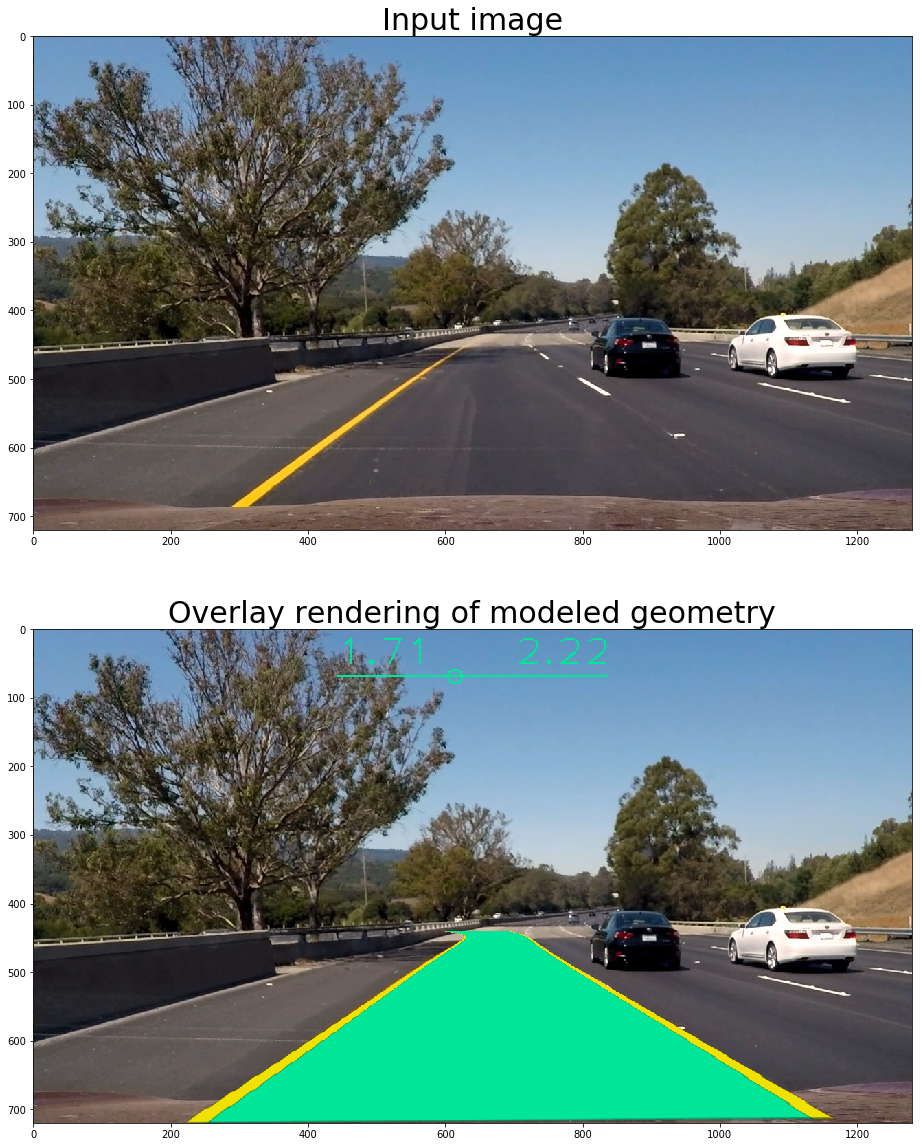

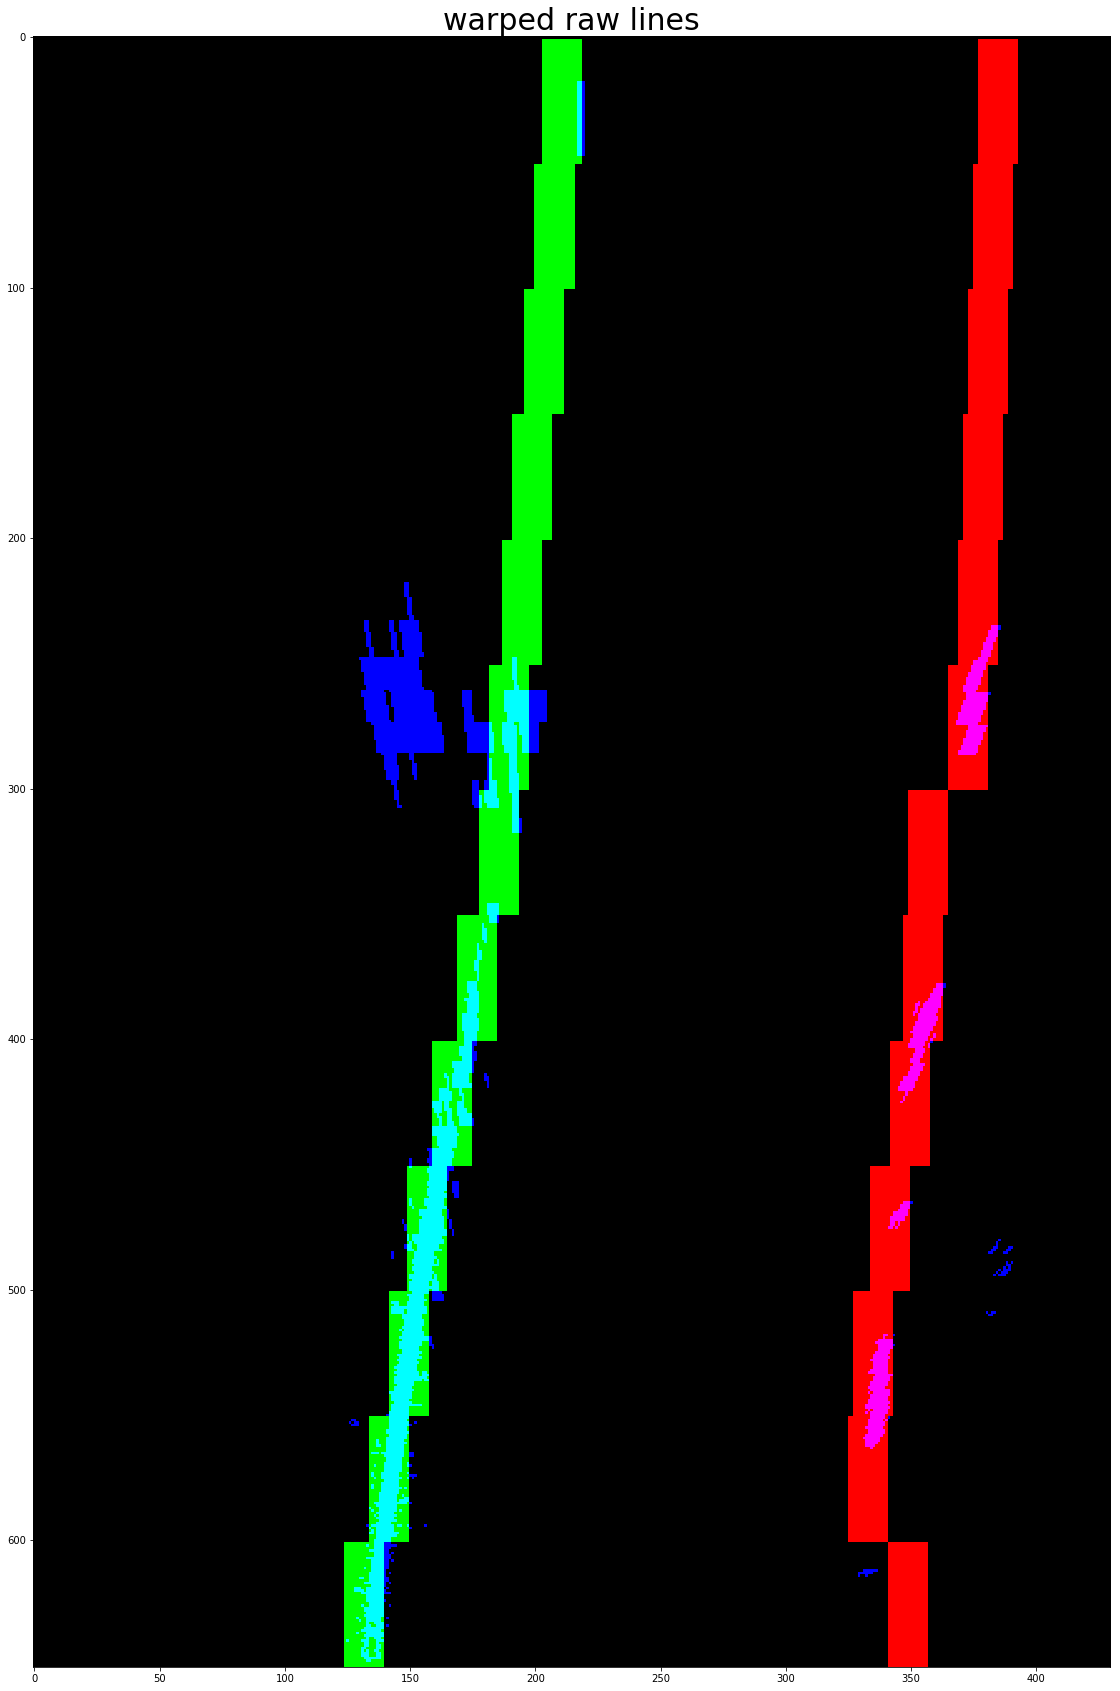

In [1]:
from classes import RoadImage, CameraCalibration,Line
import pdb
%pdb
#file ={ 'n':'hard_turn', 'h':0 }
#file = { 'n':'straight_lines1', 'h':-0.186 }
#file = { 'n':'test5', 'h':0 }
file = { 'n':'test6', 'h':0 }
#file = { 'n':'crash', 'h':0 }
#file = { 'n':'input0073', 'h':-0.2 }
#file = { 'n':'input1110', 'h':0 }
#file = { 'n':'input1210', 'h':0 }
#file = { 'n':'input1230', 'h':0 }

img = RoadImage(filename='test_images/'+file['n']+'.jpg')
#lines = RoadImage(filename='output_images/centroids'+file+'.jpg')

print('Loaded road image. Size =', img.get_size(),
      ' #ch:', RoadImage.image_channels(img))

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.275
cal.set_ahead(638,418)

# Height map
hmap = file['h']

RoadImage.extract_lines.state=None
RoadImage.find_lines.state=None

# Do the work
filter = img.extract_lines(cal)
if True:
    warped, origin = filter.warp(cal, h=hmap)
    raw = warped.channels(range(-2,1), isview=False)
    raw.colorspace = 'RGB'
    raw.channel(1)[:] = warped.centroids(x=132, lanew=205, scale=(.02,.1))
    raw.channel(0)[:] = warped.centroids(x=349, lanew=205, scale=(.02,.1))

    lines = img.find_lines(cal, h=hmap)
else:
    # For hard_turn
    warped, origin = filter.warp(cal, z=20, h=hmap, scale=(.02,.02),curvrange=(-0., 0.05))
    raw = warped.channels(range(-2,1), isview=False)
    raw.colorspace='RGB'
    raw.channel(1)[:] = warped.centroids(x=120, lanew=205, scale=(.02,.02))
    raw.channel(0)[:] = warped.centroids(x=325, lanew=205, scale=(.02,.02))
    
    lines = img.find_lines(cal, z=20, h=hmap, scale=(.02,.02),
                           method=RoadImage.centroids, save=True)

# Display centroids and extracted geometry image
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1,ax2) = plt.subplots(2,1, figsize=(20,20))
img.show(ax1, title='Input image')
lines.show(ax2, title='Overlay rendering of modeled geometry')
f, ax3 = plt.subplots(1,1, figsize=(20,30))
raw.show(ax3, title='warped raw lines')


Loaded road image. Size = (1280, 720)  #ch: 3


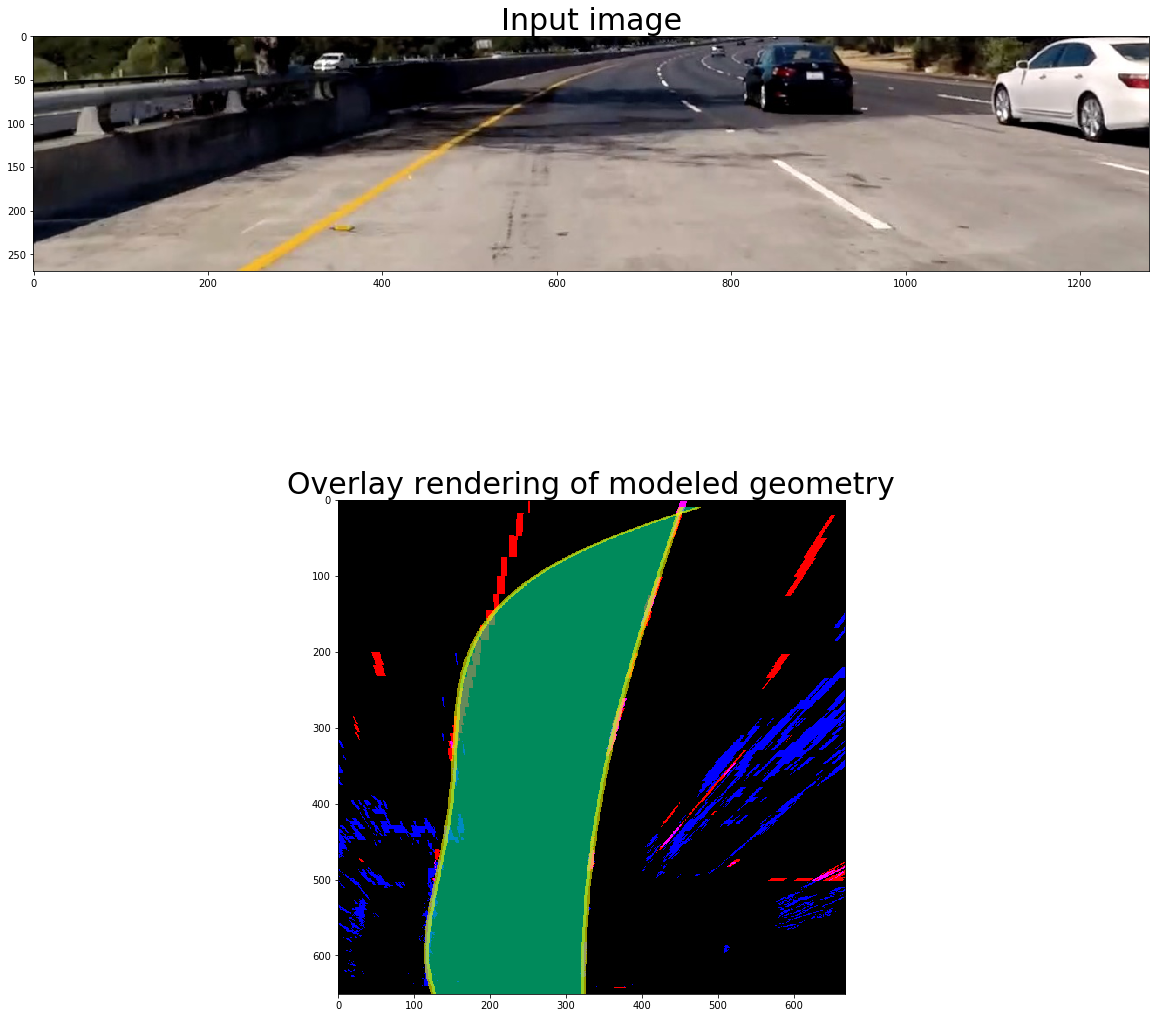

In [7]:
from classes import RoadImage, CameraCalibration,Line
import pdb
#%pdb
#file ={ 'n':'hard_turn', 'h':0 }
#file = { 'n':'straight_lines1', 'h':-0.186 }
file = { 'n':'test1', 'h':0 }
file = { 'n':'test5', 'h':0 }
#file = { 'n':'test6', 'h':0 }
#file = { 'n':'crash', 'h':0 }
#file = { 'n':'input0073', 'h':-0.2 }
#file = { 'n':'input1110', 'h':0 }
#file = { 'n':'input1210', 'h':0 }
#file = { 'n':'input1230', 'h':0 }

img = RoadImage(filename='test_images/'+file['n']+'.jpg')
#lines = RoadImage(filename='output_images/centroids'+file+'.jpg')

print('Loaded road image. Size =', img.get_size(),
      ' #ch:', RoadImage.image_channels(img))

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.275
cal.set_ahead(638,418)
img = img.undistort(cal)
#img = img[cropy]

# Height map
hmap = file['h']

#RoadImage.find_lines.state=None

# Do the work
img = img[400:670]
if file != 'hard_turn':
    lines = img.find_lines(cal, h=hmap)
else:
    # For hard_turn
    lines = img.find_lines(cal, z=20, h=hmap, scale=(.02,.02))

# Display centroids and extracted geometry image
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1,ax2) = plt.subplots(2,1, figsize=(20,20))
img.show(ax1, title='Input image')
lines.show(ax2, title='Overlay rendering of modeled geometry')


Video image extractor

In [13]:
from classes import RoadImage, CameraCalibration,Line
from classes.decorators import static_vars
from os import unlink

@static_vars(counter=0, save_input=922)
def extract_image(image):
    img = RoadImage(image, src_cspace='RGB')
    # Do the work
    extract_image.counter += 1
    if extract_image.save_input==extract_image.counter:
        print("Saving image %04d" % extract_image.counter)
        img.save('test_images/input%04d.jpg' 
                 % extract_image.counter, format='jpg')
    if extract_image.save_input<extract_image.counter:
        extract_image.counter=0
        raise StopIteration
    return image[:100,:100]

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

file = 'project_video.mp4'
file = 'challenge_video.mp4'
file = 'harder_challenge_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(37,42)
#clip1 = VideoFileClip(file).subclip(20,25)
clip1 = VideoFileClip(file)
clip = clip1.fl_image(extract_image) #NOTE: this function expects color images!!
clip.write_videofile('ramdisk/remove_me.mp4', audio=False)
unlink('ramdisk/remove_me.mp4')

[MoviePy] >>>> Building video ramdisk/remove_me.mp4
[MoviePy] Writing video ramdisk/remove_me.mp4


 76%|███████▋  | 915/1200 [00:22<00:05, 56.77it/s]

Saving image 0922


 77%|███████▋  | 921/1200 [00:22<00:08, 34.33it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ramdisk/remove_me.mp4 



Video tester, for testing ideas...

In [34]:
from classes import RoadImage, CameraCalibration
import numpy as np
import cv2

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.2
cal.set_ahead(638,418)

clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(32,8))

def warp(image):
    return image.warp(cal, z=70, h=0, scale=(.02,.1))
    
def process_image(image):
    img = RoadImage(image, src_cspace='RGB')
    # Do the work
    #gray = img.to_grayscale()
    #image = warp(gray)[0]
    #image = image.normalize(inplace=True, perchannel=False, perline=True)
    hls = img.convert_color('HLS')
    
    nda = hls.view(np.ndarray)
    #H = clahe.apply(nda[:,:,0])
    L = clahe.apply(nda[:,:,1])
    S = clahe.apply(nda[:,:,2])
    #nda[:,:,0] = H
    nda[:,:,0] = L
    nda[:,:,0] = S
    image = RoadImage(nda, src_cspace='HLS')
    #image = image.convert_color('RGB')
    image = image.to_grayscale()
    #maxis = np.max(image, axis=(-2,-1))
    #for y,m in enumerate(maxis):
    #    x = int(m)
    #    image[0,y,x,0]=255
    return image.rgb().to_int()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#file = 'project_video.mp4'
#file = 'challenge_video.mp4'
file = 'harder_challenge_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(37,42)
#clip1 = VideoFileClip(file).subclip(20,25)
clip1 = VideoFileClip(file).subclip(33,43)
#clip1 = VideoFileClip(file)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip.write_videofile('ramdisk/remove_me.mp4', audio=False)

[MoviePy] >>>> Building video ramdisk/remove_me.mp4
[MoviePy] Writing video ramdisk/remove_me.mp4


100%|█████████▉| 250/251 [00:30<00:00,  8.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ramdisk/remove_me.mp4 

